In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

In [2]:
p_data = Path("D:/Datas/covid/")

In [3]:
df = pd.read_csv(p_data / "new_training_usa.csv")
df.head()

,nationcode,date,no_policy,stayhome_cumul,edu_cumul,gathering_cumul,weakbiz_cumul,strictbiz_cumul,confirmed,cumulative
0,Alabama,2020-02-25,1,0,0,0,0,0,0,0
1,Alabama,2020-02-26,2,0,0,0,0,0,0,0
2,Alabama,2020-02-27,3,0,0,0,0,0,0,0
3,Alabama,2020-02-28,4,0,0,0,0,0,0,0
4,Alabama,2020-02-29,5,0,0,0,0,0,0,0


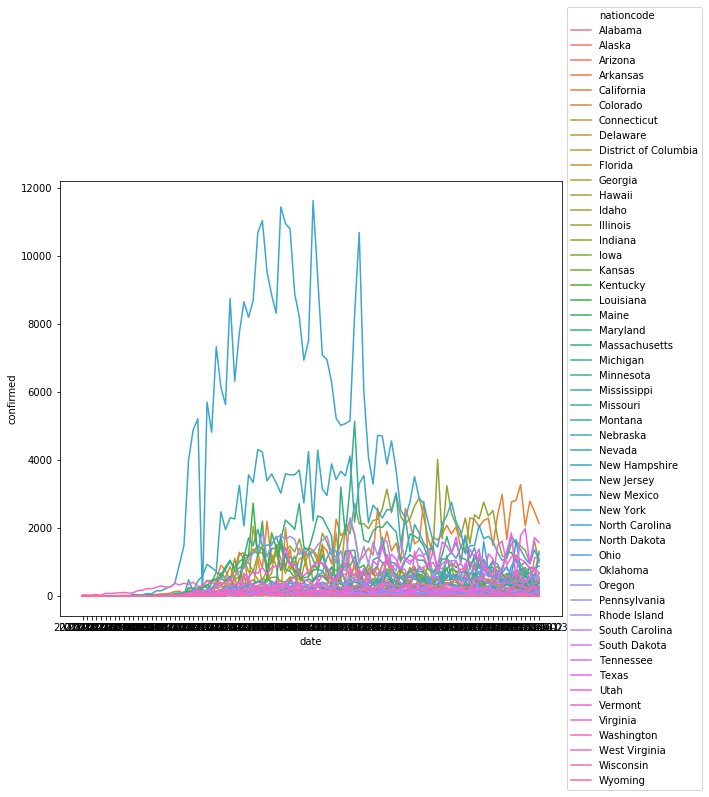

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x="date", y="confirmed", hue="nationcode", data=df, ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])
legend_x = 1
legend_y = 0.5
ax.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.show()

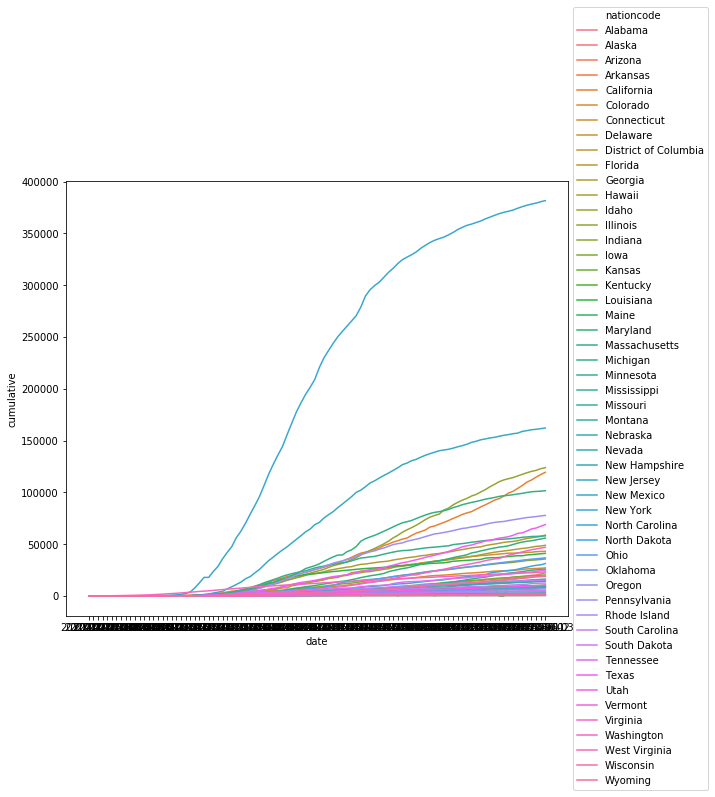

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.lineplot(x="date", y="cumulative", hue="nationcode", data=df, ax=ax)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.75, box.height])
legend_x = 1
legend_y = 0.5
ax.legend(loc='center left', bbox_to_anchor=(legend_x, legend_y))
plt.show()

In [117]:
region_code = "New York"
trg = "confirmed"

df_temp = df.loc[df["nationcode"] == region_code, :].copy()

In [124]:
corr

,no_policy,stayhome_cumul,edu_cumul,gathering_cumul,weakbiz_cumul,strictbiz_cumul,confirmed,cumulative
no_policy,1.000000,-0.422644,-0.449389,-0.494061,-0.463611,-0.422644,-0.410847,-0.478205
stayhome_cumul,-0.422644,1.000000,0.998749,0.993649,0.997370,1.000000,-0.111282,0.971195
edu_cumul,-0.449389,0.998749,1.000000,0.997748,0.999709,0.998749,-0.069354,0.976403
gathering_cumul,-0.494061,0.993649,0.997748,1.000000,0.999006,0.993649,-0.021228,0.978483
weakbiz_cumul,-0.463611,0.997370,0.999709,0.999006,1.000000,0.997370,-0.051103,0.977745
strictbiz_cumul,-0.422644,1.000000,0.998749,0.993649,0.997370,1.000000,-0.111282,0.971195
confirmed,-0.410847,-0.111282,-0.069354,-0.021228,-0.051103,-0.111282,1.000000,0.030629
cumulative,-0.478205,0.971195,0.976403,0.978483,0.977745,0.971195,0.030629,1.000000


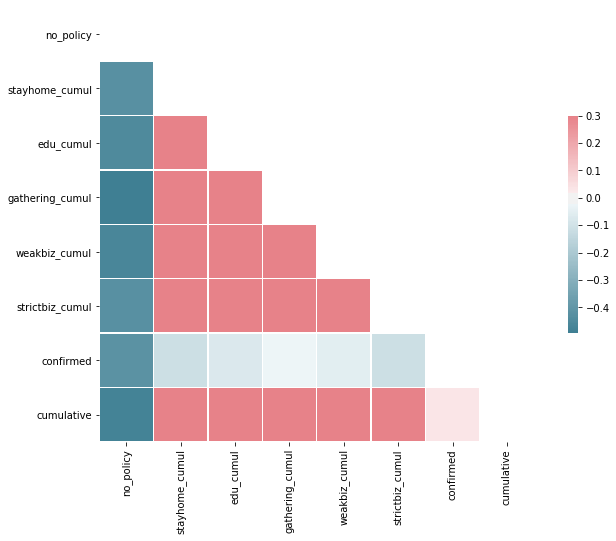

In [118]:
corr = df_temp.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.show()

In [119]:
from statsmodels.tsa.tsatools import detrend
from sklearn.preprocessing import StandardScaler

In [120]:
confirmed_ss = StandardScaler() 
cumulative_ss = StandardScaler()
v_con = detrend(confirmed_ss.fit_transform(df_temp.loc[:, "confirmed"].values.reshape(-1, 1)).reshape(-1), 
                order=2)
v_cum = detrend(cumulative_ss.fit_transform(df_temp.loc[:, "cumulative"].values.reshape(-1, 1)).reshape(-1), 
                order=3)

df_temp.loc[:, "detrend_confirmed"] = confirmed_ss.inverse_transform(v_con)
df_temp.loc[:, "detrend_cumulative"] = cumulative_ss.inverse_transform(v_cum)

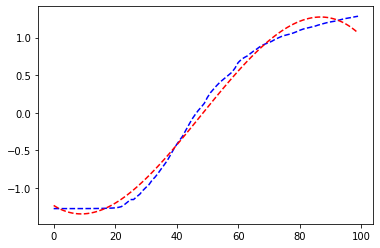

In [121]:
x = np.arange(len(df_temp))
y = cumulative_ss.fit_transform(df_temp.loc[:, "cumulative"].values.reshape(-1, 1)).reshape(-1)
model = np.polyfit(x, y, 3)
predicted = np.polyval(model, x)

plt.plot(x, y, "b--")
plt.plot(x, predicted, "r--")

In [83]:
[np.datetime64] + [np.float]*4

[numpy.datetime64, float, float, float, float]

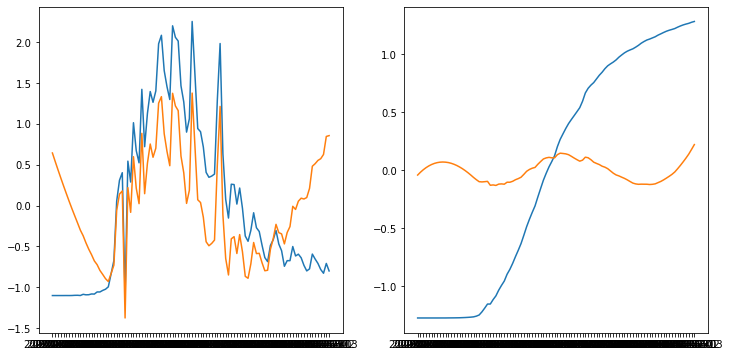

In [96]:
plot_data = pd.DataFrame(
    np.array([confirmed_ss.transform(df_temp.loc[:, "confirmed"].values.reshape(-1, 1)).reshape(-1), 
        cumulative_ss.transform(df_temp.loc[:, "cumulative"].values.reshape(-1, 1)).reshape(-1), 
        v_con, v_cum]).T,
    columns=["confirmed", "cumulative", "detrend_confirmed", "detrend_cumulative"],
)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ys, ax in zip([["confirmed", "detrend_confirmed"], ["cumulative", "detrend_cumulative"]], 
                  axes.flatten()):
    for y in ys:
        sns.lineplot(x=df_temp["date"].values, y=plot_data[y].values, ax=ax)

In [123]:
X = torch.FloatTensor(df_temp.iloc[:, 2:-4].values)
y_con = torch.FloatTensor(confirmed_ss.transform(df_temp["confirmed"].values.reshape(-1, 1)).reshape(-1))
y_cum = torch.FloatTensor(cumulative_ss.transform(df_temp["cumulative"].values.reshape(-1, 1)).reshape(-1))
y_dcon = torch.FloatTensor(confirmed_ss.transform(df_temp["detrend_confirmed"].values.reshape(-1, 1)).reshape(-1))
y_dcum = torch.FloatTensor(cumulative_ss.transform(df_temp["detrend_cumulative"].values.reshape(-1, 1)).reshape(-1))

In [104]:
df_con = df.loc[:, ("date", "nationcode", "confirmed")].set_index(["date", "nationcode"]).unstack(-1).copy()
df_con.loc[:, :] = confirmed_ss.fit_transform(df_con)

In [14]:
nations = df["nationcode"].unique()

In [52]:
df.columns

Index(['nationcode', 'date', 'no_policy', 'stayhome_cumul', 'edu_cumul',
       'gathering_cumul', 'weakbiz_cumul', 'strictbiz_cumul', 'confirmed',
       'cumulative'],
      dtype='object')

In [54]:
df["date"]

0       2020-02-25
1       2020-02-26
2       2020-02-27
3       2020-02-28
4       2020-02-29
           ...    
5095    2020-05-30
5096    2020-05-31
5097    2020-06-01
5098    2020-06-02
5099    2020-06-03
Name: date, Length: 5100, dtype: object

In [144]:
class PolicyDataset(object):
    def __init__(self, filename, policy_cols, T=14, trg="confirmed"):
        r"""
        trg: 
            - con: confirmed, 
            - ch_con: percentage increase of confirmed
            - log_ch_con: log of percentage increase of confirmed
            - cum: cumulative
            - ch_cum: percentage increase of cumulative
            - log_ch_cum: log of percentage increase of cumulative
        
        return data shape 
            - policy + region token: (policy_num + region)
            - for each region: (T, policy_num), (trg)
        
        """
        self.trg = trg
        policy_num = len(policy_cols)
        df = pd.read_csv(filename)
        
        
        df.loc[:, "trg"] = df.loc[:, trg].values
        lag_idx = 0  # if use ch_* have to +1
        
        regions = df["nationcode"].unique()
        regions_dict = {r: i for i, r in enumerate(regions)}
        region_policy_tokens = torch.cat([
            torch.arange(0, policy_num).repeat(len(regions), 1), 
            torch.LongTensor([regions_dict.get(r) for r in regions]).view(-1, 1)
        ], dim=1)
        
        
        self.datas = []
        df_temp = df.loc[:, ["nationcode"]+policy_cols+["trg"]]
        for r in regions:
            ridx = regions_dict.get(r)
            r_datas = df_temp.loc[df_temp["nationcode"] == r, policy_cols+["trg"]]
            n = len(r_datas)
            keys, X, y = [], [], []
            for idx in np.arange(lag_idx, n+lag_idx-T):
                window_data = r_datas.values[idx:idx+T, :]
                X.append(torch.FloatTensor(window_data[:, :-1]))
                y.append(window_data[-1, -1])
                keys.append(region_policy_tokens[ridx])
            keys = torch.stack(keys)
            X = torch.stack(X)  # n, T, policy_num
            y = torch.FloatTensor(y) # n
            self.datas.append((keys, X, y))
            
        
    def __len__(self):
        return len(self.datas)
    
    def __getitem__(self, idx):
        return self.datas[idx][0], self.datas[idx][1], self.datas[idx][2]

In [145]:
df.columns

Index(['nationcode', 'date', 'no_policy', 'stayhome_cumul', 'edu_cumul',
       'gathering_cumul', 'weakbiz_cumul', 'strictbiz_cumul', 'confirmed',
       'cumulative', 'trg'],
      dtype='object')

In [146]:
policy_cols = ['no_policy', 'stayhome_cumul', 'edu_cumul', 'gathering_cumul', 
               'weakbiz_cumul', 'strictbiz_cumul']
trg = "confirmed"
ds = PolicyDataset(
    filename=(p_data / "new_training_usa.csv"), policy_cols=policy_cols, T=14, trg=trg
)

In [147]:
loader = DataLoader(ds, batch_size=5)

In [154]:
for a, b, c in loader:
    break

In [155]:
a.shape

torch.Size([5, 86, 7])

In [156]:
b.shape

torch.Size([5, 86, 14, 6])

In [157]:
c.shape

torch.Size([5, 86])

In [76]:
r = "Alaska"
T = 14
lag_idx = 0

In [71]:
trg = "confirmed"
policy_cols = ['no_policy', 'stayhome_cumul', 'edu_cumul', 'gathering_cumul', 'weakbiz_cumul', 'strictbiz_cumul']
df_temp = df.loc[:, ["nationcode"]+policy_cols+["trg"]]

In [80]:
r_datas = df_temp.loc[df_temp["nationcode"] == r, policy_cols+["trg"]]

In [89]:
X, y = [], []
for idx in np.arange(lag_idx, len(r_datas)+lag_idx-T):
    window_data = r_datas.values[idx:idx+T, :]
    X.append(torch.FloatTensor(window_data[:, :-1]))
    y.append(window_data[-1, -1])

In [91]:
torch.stack(X).shape

torch.Size([86, 14, 6])

In [93]:
torch.FloatTensor(y)

tensor([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  3.,  3.,  3.,  3.,  3.,
        12.,  4.,  7., 15.,  2., 27., 17., 12.,  5., 13., 11., 14., 14., 14.,
         5., 23., 13.,  9., 11., 11., 15.,  5.,  8.,  8.,  7.,  9.,  5.,  5.,
         2.,  8.,  6.,  2.,  2.,  0.,  1.,  5.,  6.,  4.,  0.,  9.,  1.,  3.,
         2.,  1.,  1.,  2.,  3.,  1.,  1.,  0.,  4.,  0.,  0.,  5.,  0.,  0.,
         0., 12.,  1.,  0.,  2.,  4.,  0.,  1.,  2.,  1., 13.,  5.,  4., 26.,
         7., 20.])

In [24]:
policy = np.arange(0, policy_num)
regions = df["nationcode"].unique()
regions_dict = {r: i for i, r in enumerate(regions)}

In [50]:
a = torch.cat([torch.arange(0, policy_num).repeat(len(regions), 1), torch.LongTensor([regions_dict.get(r) for r in regions]).view(-1, 1)], dim=1)

In [60]:
regions_dict

{'Alabama': 0,
 'Alaska': 1,
 'Arizona': 2,
 'Arkansas': 3,
 'California': 4,
 'Colorado': 5,
 'Connecticut': 6,
 'Delaware': 7,
 'District of Columbia': 8,
 'Florida': 9,
 'Georgia': 10,
 'Hawaii': 11,
 'Idaho': 12,
 'Illinois': 13,
 'Indiana': 14,
 'Iowa': 15,
 'Kansas': 16,
 'Kentucky': 17,
 'Louisiana': 18,
 'Maine': 19,
 'Maryland': 20,
 'Massachusetts': 21,
 'Michigan': 22,
 'Minnesota': 23,
 'Mississippi': 24,
 'Missouri': 25,
 'Montana': 26,
 'Nebraska': 27,
 'Nevada': 28,
 'New Hampshire': 29,
 'New Jersey': 30,
 'New Mexico': 31,
 'New York': 32,
 'North Carolina': 33,
 'North Dakota': 34,
 'Ohio': 35,
 'Oklahoma': 36,
 'Oregon': 37,
 'Pennsylvania': 38,
 'Rhode Island': 39,
 'South Carolina': 40,
 'South Dakota': 41,
 'Tennessee': 42,
 'Texas': 43,
 'Utah': 44,
 'Vermont': 45,
 'Virginia': 46,
 'Washington': 47,
 'West Virginia': 48,
 'Wisconsin': 49,
 'Wyoming': 50}

In [49]:
torch.LongTensor([regions_dict.get(r) for r in regions]).view(-1, 1).shape

torch.Size([51, 1])

In [44]:
torch.LongTensor([regions_dict.get(r) for r in regions])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [35]:
torch.stack([torch.LongTensor(np.hstack([np.arange(0, policy_num), regions_dict.get(r)])) for r in regions])

tensor([[ 0,  1,  2,  3,  4,  5,  0],
        [ 0,  1,  2,  3,  4,  5,  1],
        [ 0,  1,  2,  3,  4,  5,  2],
        [ 0,  1,  2,  3,  4,  5,  3],
        [ 0,  1,  2,  3,  4,  5,  4],
        [ 0,  1,  2,  3,  4,  5,  5],
        [ 0,  1,  2,  3,  4,  5,  6],
        [ 0,  1,  2,  3,  4,  5,  7],
        [ 0,  1,  2,  3,  4,  5,  8],
        [ 0,  1,  2,  3,  4,  5,  9],
        [ 0,  1,  2,  3,  4,  5, 10],
        [ 0,  1,  2,  3,  4,  5, 11],
        [ 0,  1,  2,  3,  4,  5, 12],
        [ 0,  1,  2,  3,  4,  5, 13],
        [ 0,  1,  2,  3,  4,  5, 14],
        [ 0,  1,  2,  3,  4,  5, 15],
        [ 0,  1,  2,  3,  4,  5, 16],
        [ 0,  1,  2,  3,  4,  5, 17],
        [ 0,  1,  2,  3,  4,  5, 18],
        [ 0,  1,  2,  3,  4,  5, 19],
        [ 0,  1,  2,  3,  4,  5, 20],
        [ 0,  1,  2,  3,  4,  5, 21],
        [ 0,  1,  2,  3,  4,  5, 22],
        [ 0,  1,  2,  3,  4,  5, 23],
        [ 0,  1,  2,  3,  4,  5, 24],
        [ 0,  1,  2,  3,  4,  5, 25],
        [ 0,

In [31]:
np.hstack([np.arange(0, policy_num), regions_dict.get("Alabama")])

array([0, 1, 2, 3, 4, 5, 0])

In [29]:
regions_dict

{'Alabama': 0,
 'Alaska': 1,
 'Arizona': 2,
 'Arkansas': 3,
 'California': 4,
 'Colorado': 5,
 'Connecticut': 6,
 'Delaware': 7,
 'District of Columbia': 8,
 'Florida': 9,
 'Georgia': 10,
 'Hawaii': 11,
 'Idaho': 12,
 'Illinois': 13,
 'Indiana': 14,
 'Iowa': 15,
 'Kansas': 16,
 'Kentucky': 17,
 'Louisiana': 18,
 'Maine': 19,
 'Maryland': 20,
 'Massachusetts': 21,
 'Michigan': 22,
 'Minnesota': 23,
 'Mississippi': 24,
 'Missouri': 25,
 'Montana': 26,
 'Nebraska': 27,
 'Nevada': 28,
 'New Hampshire': 29,
 'New Jersey': 30,
 'New Mexico': 31,
 'New York': 32,
 'North Carolina': 33,
 'North Dakota': 34,
 'Ohio': 35,
 'Oklahoma': 36,
 'Oregon': 37,
 'Pennsylvania': 38,
 'Rhode Island': 39,
 'South Carolina': 40,
 'South Dakota': 41,
 'Tennessee': 42,
 'Texas': 43,
 'Utah': 44,
 'Vermont': 45,
 'Virginia': 46,
 'Washington': 47,
 'West Virginia': 48,
 'Wisconsin': 49,
 'Wyoming': 50}